In [1]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import pandas as pd

In [8]:
filepath=r"C:\Users\harme\Desktop\Projects\QuickDraw\eval.tfrecord-00000-of-00010"

In [9]:
quickdraw_dir=Path(filepath).parent

In [10]:
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [11]:
quickdraw_dir

WindowsPath('C:/Users/harme/Desktop/Projects/QuickDraw')

In [12]:
train_files

['C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\training.tfrecord-00009-of-00010']

In [13]:
eval_files

['C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\harme\\Desktop\\Projects\\QuickDraw\\eval.tfrecord-00009-of-00010']

In [14]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [15]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [16]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [17]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [18]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [19]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [20]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.00784314 -0.6745098   0.        ]
  [ 0.00784314 -0.10588235  0.        ]
  [ 0.02352941 -0.05490196  1.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.00393701  0.28870296  0.        ]
  [ 0.01968504  0.1213389   0.        ]
  [ 0.22047243  0.00836819  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.85779816  0.        ]
  [-0.01176471  0.03669727  0.        ]
  [ 0.8745098   0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.00392157 -0.02958581  0.        ]
  [-0.01960784 -0.01183432  0.        ]
  [-0.04313725  0.00591716  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

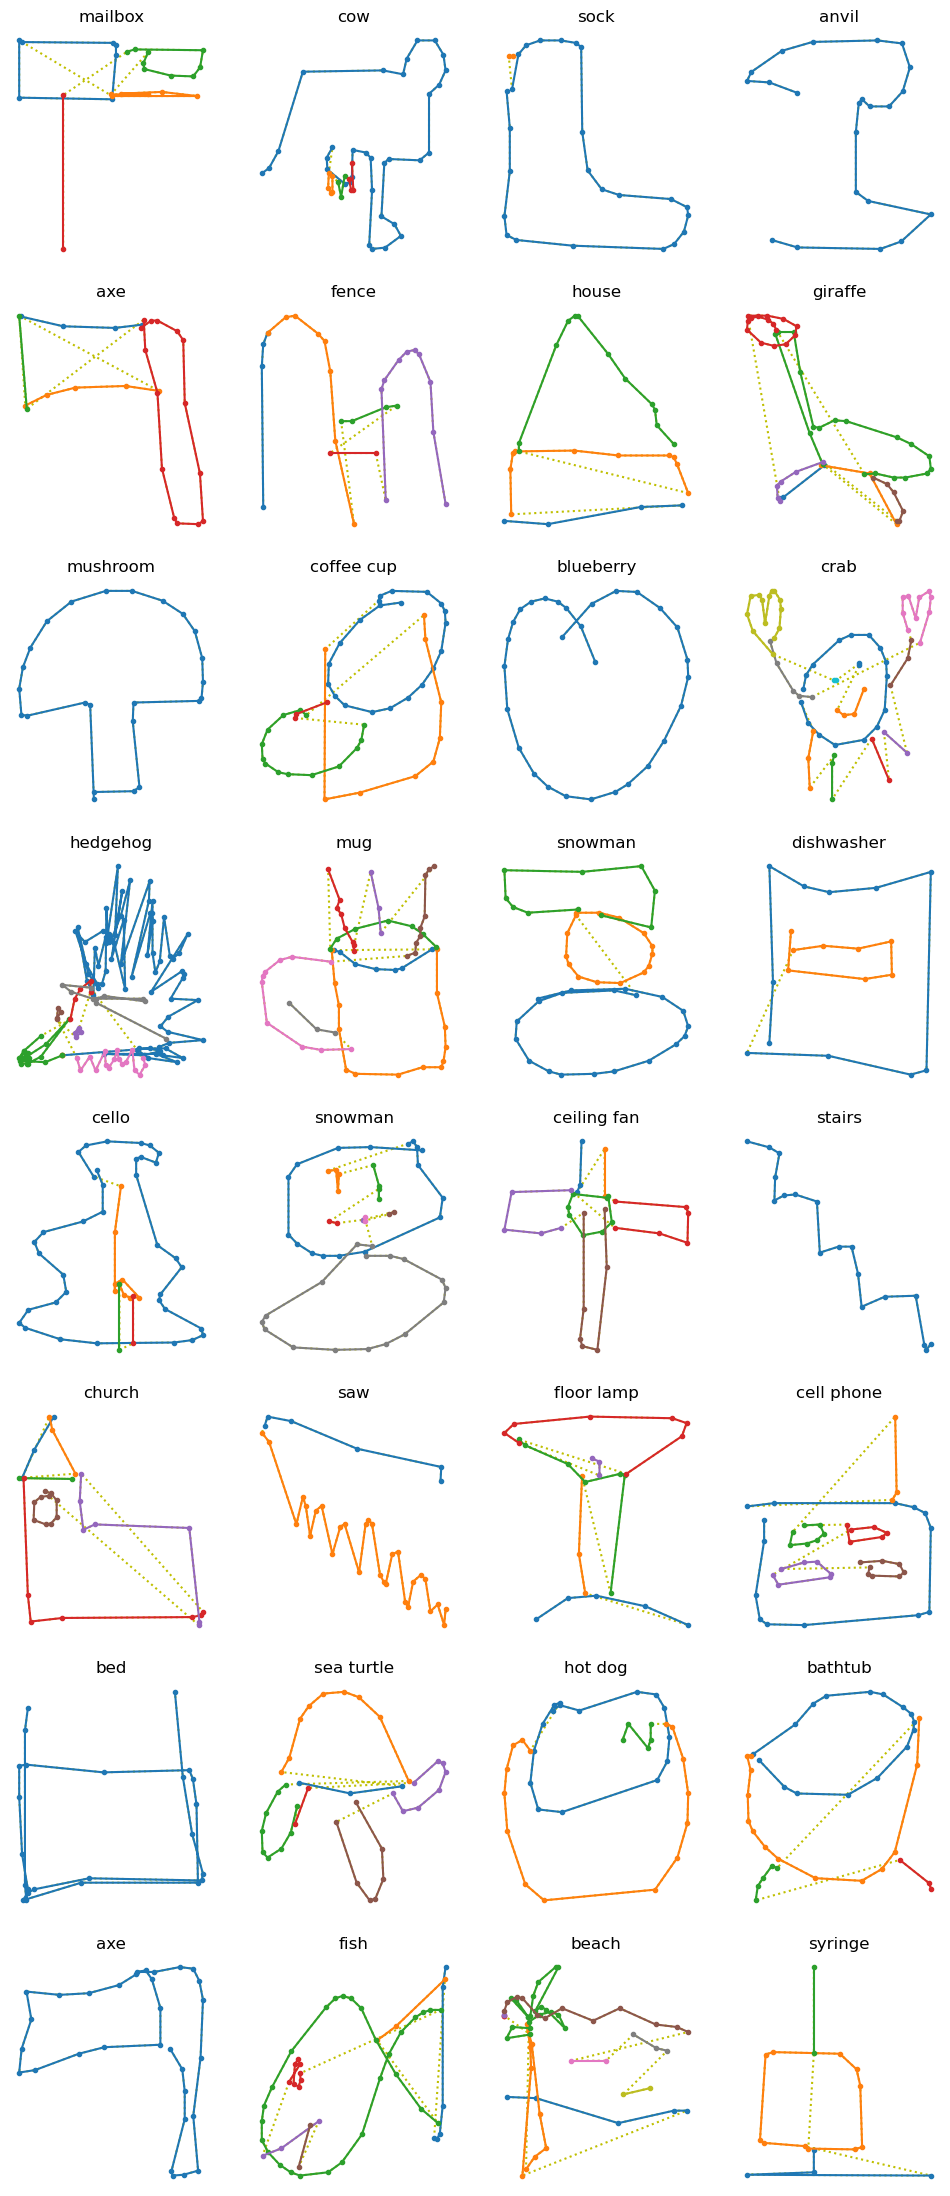

In [21]:
import matplotlib.pyplot as plt
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")
    
def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

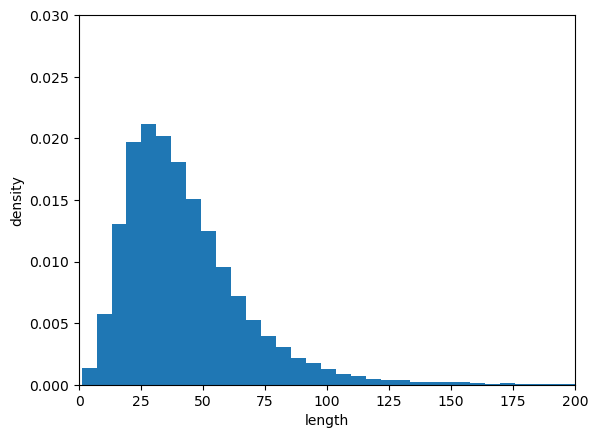

In [16]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [17]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
 107812/Unknown 2513s 23ms/step - accuracy: 0.0811 - loss: 4.8534 - sparse_top_k_categorical_accuracy: 0.2057

C:\Users\harme\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 2569s 24ms/step - accuracy: 0.0811 - loss: 4.8534 - sparse_top_k_categorical_accuracy: 0.2057 - val_accuracy: 0.3151 - val_loss: 3.0505 - val_sparse_top_k_categorical_accuracy: 0.5995
Epoch 2/2
107813/107813 ━━━━━━━━━━━━━━━━━━━━ 4227s 39ms/step - accuracy: 0.3509 - loss: 2.8566 - sparse_top_k_categorical_accuracy: 0.6400 - val_accuracy: 0.4264 - val_loss: 2.4537 - val_sparse_top_k_categorical_accuracy: 0.7155


In [19]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/step


In [20]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.6024993

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step


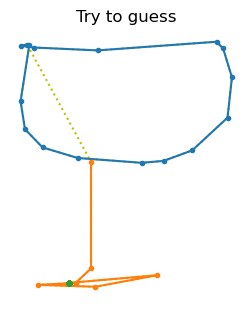

Top-5 predictions:
  1. wine glass 89.486%
  2. hot air balloon 5.322%
  3. anvil 0.900%
  4. hockey puck 0.311%
  5. floor lamp 0.303%
Answer: wine glass


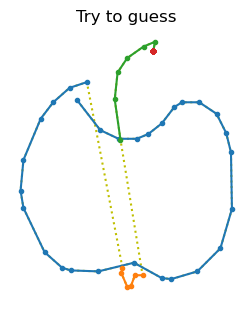

Top-5 predictions:
  1. duck 21.235%
  2. whale 8.603%
  3. steak 7.523%
  4. teapot 7.497%
  5. shoe 5.864%
Answer: apple


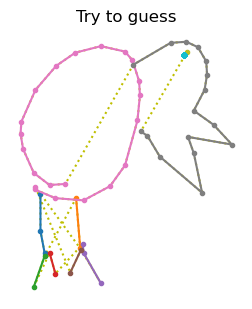

Top-5 predictions:
  1. scorpion 15.215%
  2. rhinoceros 12.360%
  3. camel 6.688%
  4. frog 6.344%
  5. horse 5.423%
Answer: parrot


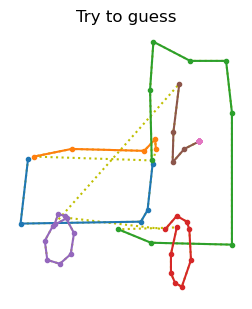

Top-5 predictions:
  1. pickup truck 39.468%
  2. truck 32.942%
  3. bulldozer 4.787%
  4. train 4.406%
  5. car 3.739%
Answer: pickup truck


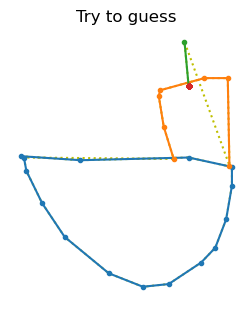

Top-5 predictions:
  1. cruise ship 47.056%
  2. sailboat 11.477%
  3. submarine 10.520%
  4. speedboat 7.847%
  5. aircraft carrier 6.747%
Answer: cruise ship


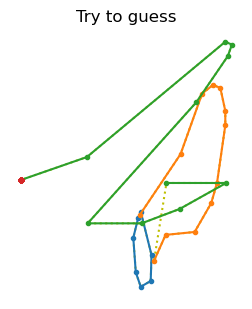

Top-5 predictions:
  1. sword 16.788%
  2. see saw 14.548%
  3. pliers 8.993%
  4. knife 8.432%
  5. trombone 5.476%
Answer: baseball bat


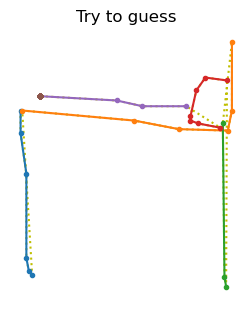

Top-5 predictions:
  1. bed 41.519%
  2. hospital 16.449%
  3. castle 9.420%
  4. church 5.112%
  5. couch 2.384%
Answer: bed


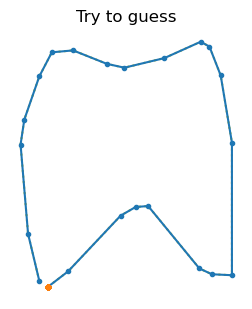

Top-5 predictions:
  1. tooth 25.114%
  2. bread 10.007%
  3. pillow 6.876%
  4. helmet 6.336%
  5. door 3.509%
Answer: tooth


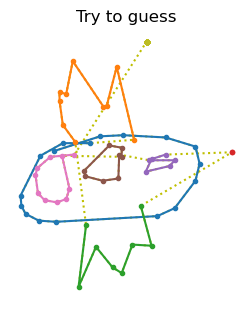

Top-5 predictions:
  1. scorpion 15.381%
  2. crab 14.103%
  3. lobster 13.124%
  4. sea turtle 4.510%
  5. airplane 2.908%
Answer: aircraft carrier


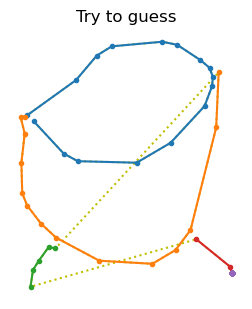

Top-5 predictions:
  1. bathtub 64.572%
  2. bottlecap 5.695%
  3. mouth 4.073%
  4. hot tub 3.999%
  5. sandwich 2.626%
Answer: bathtub


In [21]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [25]:
model.save("my_model.keras")

In [23]:
import tensorflow as tf

# Save the entire model
tf.saved_model.save(model, 'sketchrnn')


INFO:tensorflow:Assets written to: sketchrnn\assets


INFO:tensorflow:Assets written to: sketchrnn\assets


In [2]:
from tensorflow.keras.models import load_model

In [3]:
model = load_model('my_model.keras')

C:\Users\harme\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
import tensorflow as tf
import numpy as np
from PIL import Image

def load_image(image_path):
    """
    Load an image from a file path and convert it to a numpy array.

    Args:
        image_path (str): The path to the image file.

    Returns:
        np.ndarray: The image data as a numpy array.
    """
    # Load image using PIL and convert to grayscale
    image = Image.open(image_path).convert('L')  # 'L' mode for grayscale

    # Convert image to numpy array and flatten
    image_array = np.array(image).flatten()
    return image_array

def preprocess_single_image(image_array, shape, class_index):
    """
    Preprocess a single image and return the formatted data similar to TFRecord parsing.

    Args:
        image_array (np.ndarray): The flattened image data.
        shape (tuple): The shape of the image (length of the image).
        class_index (int): The class index of the image.

    Returns:
        tuple: Processed image, length, and class index.
    """
    # Ensure the image is a TensorFlow tensor
    image = tf.convert_to_tensor(image_array, dtype=tf.float32)
    
    # Convert image to sparse tensor format
    sparse_image = tf.sparse.SparseTensor(
        indices=tf.constant([[i, 0] for i in range(len(image_array))], dtype=tf.int64),  # (index, 0) format
        values=image,
        dense_shape=[len(image_array), 1]  # Assuming 1D data
    )
    
    # Convert sparse tensor to dense tensor
    flat_sketches = tf.sparse.to_dense(sparse_image)
    
    num_elements = tf.size(flat_sketches)
    # Ensure the number of elements is a multiple of 3
    if num_elements % 3 != 0:
        raise ValueError("The number of elements in the image data must be a multiple of 3 for the reshape operation.")
    
    # Reshape to the format expected by the model
    num_channels = 3
    sketches = tf.reshape(flat_sketches, shape=[1, -1, num_channels])
    
    # Create lengths and labels tensors
    lengths = tf.constant([shape[0]], dtype=tf.int64)  # Single example length
    labels = tf.constant([class_index], dtype=tf.int64)  # Single class index
    
    return sketches, lengths, labels


# Example usage:
image_path = 'Tooth.png'  # Update with your image path
image_array = load_image(image_path)

# Define the shape of the image and the class index
shape = (len(image_array),)  # Shape based on flattened image length
class_index = 10  # Example class index, update as needed

sketches, lengths, labels = preprocess_single_image(image_array, shape, class_index)

print("Sketches:", sketches)
print("Lengths:", lengths)
print("Labels:", labels)


Sketches: tf.Tensor(
[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]], shape=(1, 58838, 3), dtype=float32)
Lengths: tf.Tensor([176514], shape=(1,), dtype=int64)
Labels: tf.Tensor([10], shape=(1,), dtype=int64)


In [5]:
model.predict(sketches)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[2.8765583e-03, 1.7897376e-04, 8.8702713e-04, 2.9110521e-04,
        3.5282329e-04, 7.7599043e-04, 9.5261410e-03, 7.2046201e-04,
        2.5357105e-04, 3.8164016e-04, 3.9366819e-02, 3.1545572e-03,
        4.0149962e-04, 2.7361348e-02, 7.5219511e-03, 7.1130210e-04,
        1.0386519e-04, 1.5325675e-03, 1.3326845e-03, 9.7695121e-04,
        9.6484448e-04, 1.8531621e-04, 5.5228412e-04, 1.0146076e-03,
        1.5631376e-03, 9.1215980e-04, 1.0055010e-03, 2.9839363e-04,
        2.1222543e-03, 2.6851558e-05, 1.8194165e-03, 7.4700176e-05,
        5.3349847e-04, 1.6833847e-02, 2.6321832e-02, 5.3825660e-04,
        1.4931563e-03, 1.7475776e-03, 8.2104662e-03, 1.8804451e-04,
        2.2350420e-04, 2.2372021e-03, 2.4413907e-04, 1.5658695e-04,
        3.2571519e-03, 2.4937687e-04, 2.5782923e-03, 1.5699455e-04,
        2.3483159e-03, 2.4061286e-04, 6.9711398e-04, 1.8076821e-03,
        5.7105068e-03, 1.8658356e-03, 1.4823531e-04, 2.3685049e-03,
        1.0672888e-03, 1.6549180e-04, 5.2663013e

In [6]:
predictions=model.predict(sketches)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


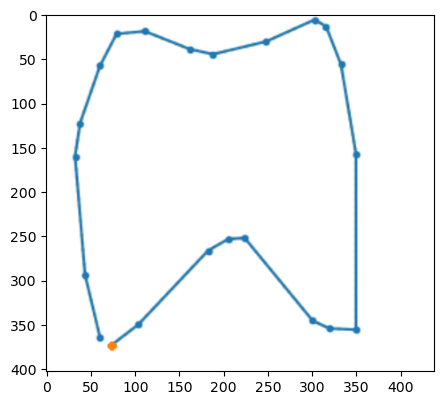

Prediction: roller coaster with probability: 0.04%


In [22]:
import matplotlib.pyplot as plt
img = Image.open(image_path)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()
top_prediction_index = tf.argmax(predictions, axis=1).numpy()[0]
top_prediction_probability = tf.reduce_max(predictions, axis=1).numpy()[0]
predicted_class_name = class_names[top_prediction_index]
print(f"Prediction: {predicted_class_name} with probability: {top_prediction_probability:.2f}%")